# Deep Q-Network (DQN)
---
In this notebook, you will implement a DQN agent with OpenAI Gym's LunarLander-v2 environment.

### 1. Import the Necessary Packages

In [1]:
import gym
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
import time

%matplotlib inline

### 2. Instantiate the Environment and Agent

Initialize the environment in the code cell below.

In [2]:
env = gym.make('LunarLander-v2')
env.seed(0)
print('State shape: ', env.observation_space.shape)
print('Number of actions: ', env.action_space.n)

State shape:  (8,)
Number of actions:  4


/home/mohamed/Downloads/gym/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Please refer to the instructions in `Deep_Q_Network.ipynb` if you would like to write your own DQN agent.  Otherwise, run the code cell below to load the solution files.

In [3]:
from dqn_agent import Agent

agent = Agent(state_size=8, action_size=4, seed=0)

# watch an untrained agent
state = env.reset()
for j in range(200):
    action = agent.act(state)
    env.render()
    state, reward, done, _ = env.step(action)
    if done:
        break 
        
env.close()

### 3. Train the Agent with DQN

Run the code cell below to train the agent from scratch.  You are welcome to amend the supplied values of the parameters in the function, to try to see if you can get better performance!

Alternatively, you can skip to the next step below (**4. Watch a Smart Agent!**), to load the saved model weights from a pre-trained agent.

Episode 100	Average Score: -168.32
Episode 200	Average Score: -101.62
Episode 300	Average Score: -35.678
Episode 400	Average Score: -2.799
Episode 500	Average Score: 96.78
Episode 600	Average Score: 188.79
Episode 617	Average Score: 200.29
Environment solved in 517 episodes!	Average Score: 200.29


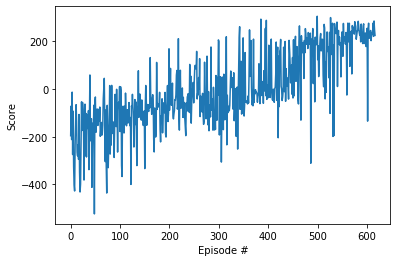

In [4]:
def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=200.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores

scores = dqn()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 4. Watch a Smart Agent!

In the next code cell, you will load the trained weights from file to watch a smart agent!

In [5]:
# load the weights from file
agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))

for i in range(3):
    state = env.reset()
    for j in range(500):
        action = agent.act(state)
        env.render()
        state, reward, done, _ = env.step(action)
        if done:
            print(reward)
            break 
        time.sleep(0.01)
            
env.close()

-100
100


### 5. Explore

In this exercise, you have implemented a DQN agent and demonstrated how to use it to solve an OpenAI Gym environment.  To continue your learning, you are encouraged to complete any (or all!) of the following tasks:
- Amend the various hyperparameters and network architecture to see if you can get your agent to solve the environment faster.  Once you build intuition for the hyperparameters that work well with this environment, try solving a different OpenAI Gym task with discrete actions!
- You may like to implement some improvements such as prioritized experience replay, Double DQN, or Dueling DQN! 
- Write a blog post explaining the intuition behind the DQN algorithm and demonstrating how to use it to solve an RL environment of your choosing.  

In [ ]:
#!/usr/bin/env python

import time
import os
import random
import threading
import argparse
import matplotlib.pyplot as plt
import numpy as np
import scipy as sc
import cv2
from collections import namedtuple
import torch
from torch.autograd import Variable
from robot import Robot
from trainer import Trainer
from logger import Logger
import utils


def main(args):


    # --------------- Setup options ---------------
    is_sim = args.is_sim # Run in simulation?
    obj_mesh_dir = os.path.abspath(args.obj_mesh_dir) if is_sim else None # Directory containing 3D mesh files (.obj) of objects to be added to simulation
    num_obj = args.num_obj if is_sim else None # Number of objects to add to simulation
    tcp_host_ip = args.tcp_host_ip if not is_sim else None # IP and port to robot arm as TCP client (UR5)
    tcp_port = args.tcp_port if not is_sim else None
    rtc_host_ip = args.rtc_host_ip if not is_sim else None # IP and port to robot arm as real-time client (UR5)
    rtc_port = args.rtc_port if not is_sim else None
    if is_sim:
        workspace_limits = np.asarray([[-0.724, -0.276], [-0.224, 0.224], [-0.0001, 0.4]]) # Cols: min max, Rows: x y z (define workspace limits in robot coordinates)
    else:
        workspace_limits = np.asarray([[0.3, 0.748], [-0.224, 0.224], [-0.255, -0.1]]) # Cols: min max, Rows: x y z (define workspace limits in robot coordinates)
    heightmap_resolution = args.heightmap_resolution # Meters per pixel of heightmap
    random_seed = args.random_seed
    force_cpu = args.force_cpu

    # ------------- Algorithm options -------------
    method = args.method # 'reactive' (supervised learning) or 'reinforcement' (reinforcement learning ie Q-learning)
    push_rewards = args.push_rewards if method == 'reinforcement' else None  # Use immediate rewards (from change detection) for pushing?
    future_reward_discount = args.future_reward_discount
    experience_replay = args.experience_replay # Use prioritized experience replay?
    heuristic_bootstrap = args.heuristic_bootstrap # Use handcrafted grasping algorithm when grasping fails too many times in a row?
    explore_rate_decay = args.explore_rate_decay
    grasp_only = args.grasp_only

    # -------------- Testing options --------------
    is_testing = args.is_testing
    max_test_trials = args.max_test_trials # Maximum number of test runs per case/scenario
    test_preset_cases = args.test_preset_cases
    test_preset_file = os.path.abspath(args.test_preset_file) if test_preset_cases else None

    # ------ Pre-loading and logging options ------
    load_snapshot = args.load_snapshot # Load pre-trained snapshot of model?
    snapshot_file = os.path.abspath(args.snapshot_file)  if load_snapshot else None
    continue_logging = args.continue_logging # Continue logging from previous session
    logging_directory = os.path.abspath(args.logging_directory) if continue_logging else os.path.abspath('logs')
    save_visualizations = args.save_visualizations # Save visualizations of FCN predictions? Takes 0.6s per training step if set to True


    # Set random seed
    np.random.seed(random_seed)

    # Initialize pick-and-place system (camera and robot)
    robot = Robot(is_sim, obj_mesh_dir, num_obj, workspace_limits,
                  tcp_host_ip, tcp_port, rtc_host_ip, rtc_port,
                  is_testing, test_preset_cases, test_preset_file)

    # Initialize trainer
    trainer = Trainer(method, push_rewards, future_reward_discount,
                      is_testing, load_snapshot, snapshot_file, force_cpu)

    # Initialize data logger
    logger = Logger(continue_logging, logging_directory)
    logger.save_camera_info(robot.cam_intrinsics, robot.cam_pose, robot.cam_depth_scale) # Save camera intrinsics and pose
    logger.save_heightmap_info(workspace_limits, heightmap_resolution) # Save heightmap parameters

    # Find last executed iteration of pre-loaded log, and load execution info and RL variables
    if continue_logging:
        trainer.preload(logger.transitions_directory)

    # Initialize variables for heuristic bootstrapping and exploration probability
    no_change_count = [2, 2] if not is_testing else [0, 0]
    explore_prob = 0.5 if not is_testing else 0.0

    # Quick hack for nonlocal memory between threads in Python 2
    nonlocal_variables = {'executing_action' : False,
                          'primitive_action' : None,
                          'best_pix_ind' : None,
                          'push_success' : False,
                          'grasp_success' : False}


    # Parallel thread to process network output and execute actions
    # -------------------------------------------------------------
    def process_actions():
        while True:
            if nonlocal_variables['executing_action']:

                # Determine whether grasping or pushing should be executed based on network predictions
                best_push_conf = np.max(push_predictions)
                best_grasp_conf = np.max(grasp_predictions)
                print('Primitive confidence scores: %f (push), %f (grasp)' % (best_push_conf, best_grasp_conf))
                nonlocal_variables['primitive_action'] = 'grasp'
                explore_actions = False
                if not grasp_only:
                    if is_testing and method == 'reactive':
                        if best_push_conf > 2*best_grasp_conf:
                            nonlocal_variables['primitive_action'] = 'push'
                    else:
                        if best_push_conf > best_grasp_conf:
                            nonlocal_variables['primitive_action'] = 'push'
                    explore_actions = np.random.uniform() < explore_prob
                    if explore_actions: # Exploitation (do best action) vs exploration (do other action)
                        print('Strategy: explore (exploration probability: %f)' % (explore_prob))
                        nonlocal_variables['primitive_action'] = 'push' if np.random.randint(0,2) == 0 else 'grasp'
                    else:
                        print('Strategy: exploit (exploration probability: %f)' % (explore_prob))
                trainer.is_exploit_log.append([0 if explore_actions else 1])
                logger.write_to_log('is-exploit', trainer.is_exploit_log)

                # If heuristic bootstrapping is enabled: if change has not been detected more than 2 times, execute heuristic algorithm to detect grasps/pushes
                # NOTE: typically not necessary and can reduce final performance.
                if heuristic_bootstrap and nonlocal_variables['primitive_action'] == 'push' and no_change_count[0] >= 2:
                    print('Change not detected for more than two pushes. Running heuristic pushing.')
                    nonlocal_variables['best_pix_ind'] = trainer.push_heuristic(valid_depth_heightmap)
                    no_change_count[0] = 0
                    predicted_value = push_predictions[nonlocal_variables['best_pix_ind']]
                    use_heuristic = True
                elif heuristic_bootstrap and nonlocal_variables['primitive_action'] == 'grasp' and no_change_count[1] >= 2:
                    print('Change not detected for more than two grasps. Running heuristic grasping.')
                    nonlocal_variables['best_pix_ind'] = trainer.grasp_heuristic(valid_depth_heightmap)
                    no_change_count[1] = 0
                    predicted_value = grasp_predictions[nonlocal_variables['best_pix_ind']]
                    use_heuristic = True
                else:
                    use_heuristic = False

                    # Get pixel location and rotation with highest affordance prediction from heuristic algorithms (rotation, y, x)
                    if nonlocal_variables['primitive_action'] == 'push':
                        nonlocal_variables['best_pix_ind'] = np.unravel_index(np.argmax(push_predictions), push_predictions.shape)
                        predicted_value = np.max(push_predictions)
                    elif nonlocal_variables['primitive_action'] == 'grasp':
                        nonlocal_variables['best_pix_ind'] = np.unravel_index(np.argmax(grasp_predictions), grasp_predictions.shape)
                        predicted_value = np.max(grasp_predictions)
                trainer.use_heuristic_log.append([1 if use_heuristic else 0])
                logger.write_to_log('use-heuristic', trainer.use_heuristic_log)

                # Save predicted confidence value
                trainer.predicted_value_log.append([predicted_value])
                logger.write_to_log('predicted-value', trainer.predicted_value_log)

                # Compute 3D position of pixel
                print('Action: %s at (%d, %d, %d)' % (nonlocal_variables['primitive_action'], nonlocal_variables['best_pix_ind'][0], nonlocal_variables['best_pix_ind'][1], nonlocal_variables['best_pix_ind'][2]))
                best_rotation_angle = np.deg2rad(nonlocal_variables['best_pix_ind'][0]*(360.0/trainer.model.num_rotations))
                best_pix_x = nonlocal_variables['best_pix_ind'][2]
                best_pix_y = nonlocal_variables['best_pix_ind'][1]
                primitive_position = [best_pix_x * heightmap_resolution + workspace_limits[0][0], best_pix_y * heightmap_resolution + workspace_limits[1][0], valid_depth_heightmap[best_pix_y][best_pix_x] + workspace_limits[2][0]]

                # If pushing, adjust start position, and make sure z value is safe and not too low
                if nonlocal_variables['primitive_action'] == 'push': # or nonlocal_variables['primitive_action'] == 'place':
                    finger_width = 0.02
                    safe_kernel_width = int(np.round((finger_width/2)/heightmap_resolution))
                    local_region = valid_depth_heightmap[max(best_pix_y - safe_kernel_width, 0):min(best_pix_y + safe_kernel_width + 1, valid_depth_heightmap.shape[0]), max(best_pix_x - safe_kernel_width, 0):min(best_pix_x + safe_kernel_width + 1, valid_depth_heightmap.shape[1])]
                    if local_region.size == 0:
                        safe_z_position = workspace_limits[2][0]
                    else:
                        safe_z_position = np.max(local_region) + workspace_limits[2][0]
                    primitive_position[2] = safe_z_position

                # Save executed primitive
                if nonlocal_variables['primitive_action'] == 'push':
                    trainer.executed_action_log.append([0, nonlocal_variables['best_pix_ind'][0], nonlocal_variables['best_pix_ind'][1], nonlocal_variables['best_pix_ind'][2]]) # 0 - push
                elif nonlocal_variables['primitive_action'] == 'grasp':
                    trainer.executed_action_log.append([1, nonlocal_variables['best_pix_ind'][0], nonlocal_variables['best_pix_ind'][1], nonlocal_variables['best_pix_ind'][2]]) # 1 - grasp
                logger.write_to_log('executed-action', trainer.executed_action_log)

                # Visualize executed primitive, and affordances
                if save_visualizations:
                    push_pred_vis = trainer.get_prediction_vis(push_predictions, color_heightmap, nonlocal_variables['best_pix_ind'])
                    logger.save_visualizations(trainer.iteration, push_pred_vis, 'push')
                    cv2.imwrite('visualization.push.png', push_pred_vis)
                    grasp_pred_vis = trainer.get_prediction_vis(grasp_predictions, color_heightmap, nonlocal_variables['best_pix_ind'])
                    logger.save_visualizations(trainer.iteration, grasp_pred_vis, 'grasp')
                    cv2.imwrite('visualization.grasp.png', grasp_pred_vis)

                # Initialize variables that influence reward
                nonlocal_variables['push_success'] = False
                nonlocal_variables['grasp_success'] = False
                change_detected = False

                # Execute primitive
                if nonlocal_variables['primitive_action'] == 'push':
                    nonlocal_variables['push_success'] = robot.push(primitive_position, best_rotation_angle, workspace_limits)
                    print('Push successful: %r' % (nonlocal_variables['push_success']))
                elif nonlocal_variables['primitive_action'] == 'grasp':
                    nonlocal_variables['grasp_success'] = robot.grasp(primitive_position, best_rotation_angle, workspace_limits)
                    print('Grasp successful: %r' % (nonlocal_variables['grasp_success']))

                nonlocal_variables['executing_action'] = False

            time.sleep(0.01)
    action_thread = threading.Thread(target=process_actions)
    action_thread.daemon = True
    action_thread.start()
    exit_called = False
    # -------------------------------------------------------------
    # -------------------------------------------------------------


    # Start main training/testing loop
    while True:
        print('\n%s iteration: %d' % ('Testing' if is_testing else 'Training', trainer.iteration))
        iteration_time_0 = time.time()

        # Get latest RGB-D image
        color_img, depth_img = robot.get_camera_data()
        depth_img = depth_img * robot.cam_depth_scale # Apply depth scale from calibration

        # Get heightmap from RGB-D image (by re-projecting 3D point cloud)
        color_heightmap, depth_heightmap = utils.get_heightmap(color_img, depth_img, robot.cam_intrinsics, robot.cam_pose, workspace_limits, heightmap_resolution)
        valid_depth_heightmap = depth_heightmap.copy()
        valid_depth_heightmap[np.isnan(valid_depth_heightmap)] = 0

        # Save RGB-D images and RGB-D heightmaps
        logger.save_images(trainer.iteration, color_img, depth_img, '0')
        logger.save_heightmaps(trainer.iteration, color_heightmap, valid_depth_heightmap, '0')

        # Run forward pass with network to get affordances
        push_predictions, grasp_predictions, state_feat = trainer.forward(color_heightmap, valid_depth_heightmap, is_volatile=True)

        # Execute best primitive action on robot in another thread
        nonlocal_variables['executing_action'] = True
        
        # Determine whether grasping or pushing should be executed based on network predictions
        best_grasp_conf = np.max(grasp_predictions)
        print('Primitive confidence scores: %f (grasp)' % (best_grasp_conf))
        nonlocal_variables['primitive_action'] = 'grasp'
        explore_actions = False
        trainer.is_exploit_log.append([0 if explore_actions else 1])
        logger.write_to_log('is-exploit', trainer.is_exploit_log)


        use_heuristic = False
            
        nonlocal_variables['best_pix_ind'] = np.unravel_index(np.argmax(grasp_predictions), grasp_predictions.shape)
        predicted_value = np.max(grasp_predictions)
        trainer.use_heuristic_log.append([1 if use_heuristic else 0])
        logger.write_to_log('use-heuristic', trainer.use_heuristic_log)

        # Save predicted confidence value
        trainer.predicted_value_log.append([predicted_value])
        logger.write_to_log('predicted-value', trainer.predicted_value_log)
        
        
        
        # Compute 3D position of pixel
        print('Action: %s at (%d, %d, %d)' % (nonlocal_variables['primitive_action'], nonlocal_variables['best_pix_ind'][0], nonlocal_variables['best_pix_ind'][1], nonlocal_variables['best_pix_ind'][2]))
        best_rotation_angle = np.deg2rad(nonlocal_variables['best_pix_ind'][0]*(360.0/trainer.model.num_rotations))
        best_pix_x = nonlocal_variables['best_pix_ind'][2]
        best_pix_y = nonlocal_variables['best_pix_ind'][1]
        primitive_position = [best_pix_x * heightmap_resolution + workspace_limits[0][0], best_pix_y * heightmap_resolution + workspace_limits[1][0], valid_depth_heightmap[best_pix_y][best_pix_x] + workspace_limits[2][0]]

         # Save executed primitive
        trainer.executed_action_log.append([1, nonlocal_variables['best_pix_ind'][0], nonlocal_variables['best_pix_ind'][1], nonlocal_variables['best_pix_ind'][2]]) # 1 - grasp
        logger.write_to_log('executed-action', trainer.executed_action_log)


        # Visualize executed primitive, and affordances
        if save_visualizations:
            grasp_pred_vis = trainer.get_prediction_vis(grasp_predictions, color_heightmap, nonlocal_variables['best_pix_ind'])
            logger.save_visualizations(trainer.iteration, grasp_pred_vis, 'grasp')
            cv2.imwrite('visualization.grasp.png', grasp_pred_vis)

        # Initialize variables that influence reward
        nonlocal_variables['grasp_success'] = False
        change_detected = False

        # Execute primitive
        nonlocal_variables['grasp_success'] = robot.grasp(primitive_position, best_rotation_angle, workspace_limits)
        print('Grasp successful: %r' % (nonlocal_variables['grasp_success']))

        nonlocal_variables['executing_action'] = False


#         time.sleep(0.01)
#         action_thread = threading.Thread(target=process_actions)
#         action_thread.daemon = True
#         action_thread.start()
#         exit_called = False        

        
        
        

        # Run training iteration in current thread (aka training thread)
        if 'prev_color_img' in locals():

            # Detect changes
            depth_diff = abs(depth_heightmap - prev_depth_heightmap)
            depth_diff[np.isnan(depth_diff)] = 0
            depth_diff[depth_diff > 0.3] = 0
            depth_diff[depth_diff < 0.01] = 0
            depth_diff[depth_diff > 0] = 1
            change_threshold = 300
            change_value = np.sum(depth_diff)
            change_detected = change_value > change_threshold or prev_grasp_success
            print('Change detected: %r (value: %d)' % (change_detected, change_value))

            if change_detected:
                if prev_primitive_action == 'push':
                    no_change_count[0] = 0
                elif prev_primitive_action == 'grasp':
                    no_change_count[1] = 0
            else:
                if prev_primitive_action == 'push':
                    no_change_count[0] += 1
                elif prev_primitive_action == 'grasp':
                    no_change_count[1] += 1

            # Compute training labels
            label_value, prev_reward_value = trainer.get_label_value(prev_primitive_action, prev_push_success, prev_grasp_success, change_detected, prev_push_predictions, prev_grasp_predictions, color_heightmap, valid_depth_heightmap)
            trainer.label_value_log.append([label_value])
            logger.write_to_log('label-value', trainer.label_value_log)
            trainer.reward_value_log.append([prev_reward_value])
            logger.write_to_log('reward-value', trainer.reward_value_log)

            # Backpropagate
            trainer.backprop(prev_color_heightmap, prev_valid_depth_heightmap, prev_primitive_action, prev_best_pix_ind, label_value)

            # Adjust exploration probability
            if not is_testing:
                explore_prob = max(0.5 * np.power(0.9998, trainer.iteration),0.1) if explore_rate_decay else 0.5

            # Do sampling for experience replay
            if experience_replay and not is_testing:
                sample_primitive_action = prev_primitive_action
                if sample_primitive_action == 'push':
                    sample_primitive_action_id = 0
                    if method == 'reactive':
                        sample_reward_value = 0 if prev_reward_value == 1 else 1 # random.randint(1, 2) # 2
                    elif method == 'reinforcement':
                        sample_reward_value = 0 if prev_reward_value == 0.5 else 0.5
                elif sample_primitive_action == 'grasp':
                    sample_primitive_action_id = 1
                    if method == 'reactive':
                        sample_reward_value = 0 if prev_reward_value == 1 else 1
                    elif method == 'reinforcement':
                        sample_reward_value = 0 if prev_reward_value == 1 else 1

                # Get samples of the same primitive but with different results
                sample_ind = np.argwhere(np.logical_and(np.asarray(trainer.reward_value_log)[1:trainer.iteration,0] == sample_reward_value, np.asarray(trainer.executed_action_log)[1:trainer.iteration,0] == sample_primitive_action_id))

                if sample_ind.size > 0:

                    # Find sample with highest surprise value
                    if method == 'reactive':
                        sample_surprise_values = np.abs(np.asarray(trainer.predicted_value_log)[sample_ind[:,0]] - (1 - sample_reward_value))
                    elif method == 'reinforcement':
                        sample_surprise_values = np.abs(np.asarray(trainer.predicted_value_log)[sample_ind[:,0]] - np.asarray(trainer.label_value_log)[sample_ind[:,0]])
                    sorted_surprise_ind = np.argsort(sample_surprise_values[:,0])
                    sorted_sample_ind = sample_ind[sorted_surprise_ind,0]
                    pow_law_exp = 2
                    rand_sample_ind = int(np.round(np.random.power(pow_law_exp, 1)*(sample_ind.size-1)))
                    sample_iteration = sorted_sample_ind[rand_sample_ind]
                    print('Experience replay: iteration %d (surprise value: %f)' % (sample_iteration, sample_surprise_values[sorted_surprise_ind[rand_sample_ind]]))

                    # Load sample RGB-D heightmap
                    sample_color_heightmap = cv2.imread(os.path.join(logger.color_heightmaps_directory, '%06d.0.color.png' % (sample_iteration)))
                    sample_color_heightmap = cv2.cvtColor(sample_color_heightmap, cv2.COLOR_BGR2RGB)
                    sample_depth_heightmap = cv2.imread(os.path.join(logger.depth_heightmaps_directory, '%06d.0.depth.png' % (sample_iteration)), -1)
                    sample_depth_heightmap = sample_depth_heightmap.astype(np.float32)/100000

                    # Compute forward pass with sample
                    with torch.no_grad():
                        sample_push_predictions, sample_grasp_predictions, sample_state_feat = trainer.forward(sample_color_heightmap, sample_depth_heightmap, is_volatile=True)

                    # Load next sample RGB-D heightmap
                    next_sample_color_heightmap = cv2.imread(os.path.join(logger.color_heightmaps_directory, '%06d.0.color.png' % (sample_iteration+1)))
                    next_sample_color_heightmap = cv2.cvtColor(next_sample_color_heightmap, cv2.COLOR_BGR2RGB)
                    next_sample_depth_heightmap = cv2.imread(os.path.join(logger.depth_heightmaps_directory, '%06d.0.depth.png' % (sample_iteration+1)), -1)
                    next_sample_depth_heightmap = next_sample_depth_heightmap.astype(np.float32)/100000

                    sample_push_success = sample_reward_value == 0.5
                    sample_grasp_success = sample_reward_value == 1
                    sample_change_detected = sample_push_success
                    # new_sample_label_value, _ = trainer.get_label_value(sample_primitive_action, sample_push_success, sample_grasp_success, sample_change_detected, sample_push_predictions, sample_grasp_predictions, next_sample_color_heightmap, next_sample_depth_heightmap)

                    # Get labels for sample and backpropagate
                    sample_best_pix_ind = (np.asarray(trainer.executed_action_log)[sample_iteration,1:4]).astype(int)
                    trainer.backprop(sample_color_heightmap, sample_depth_heightmap, sample_primitive_action, sample_best_pix_ind, trainer.label_value_log[sample_iteration])

                    # Recompute prediction value and label for replay buffer
                    if sample_primitive_action == 'push':
                        trainer.predicted_value_log[sample_iteration] = [np.max(sample_push_predictions)]
                        # trainer.label_value_log[sample_iteration] = [new_sample_label_value]
                    elif sample_primitive_action == 'grasp':
                        trainer.predicted_value_log[sample_iteration] = [np.max(sample_grasp_predictions)]
                        # trainer.label_value_log[sample_iteration] = [new_sample_label_value]

                else:
                    print('Not enough prior training samples. Skipping experience replay.')

            # Save model snapshot
            if not is_testing:
                logger.save_backup_model(trainer.model, method)
                if trainer.iteration % 50 == 0:
                    logger.save_model(trainer.iteration, trainer.model, method)
                    if trainer.use_cuda:
                        trainer.model = trainer.model.cuda()

        # Sync both action thread and training thread
        while nonlocal_variables['executing_action']:
            time.sleep(0.01)

        if exit_called:
            break

        # Save information for next training step
        prev_color_img = color_img.copy()
        prev_depth_img = depth_img.copy()
        prev_color_heightmap = color_heightmap.copy()
        prev_depth_heightmap = depth_heightmap.copy()
        prev_valid_depth_heightmap = valid_depth_heightmap.copy()
        prev_push_success = nonlocal_variables['push_success']
        prev_grasp_success = nonlocal_variables['grasp_success']
        prev_primitive_action = nonlocal_variables['primitive_action']
        prev_push_predictions = push_predictions.copy()
        prev_grasp_predictions = grasp_predictions.copy()
        prev_best_pix_ind = nonlocal_variables['best_pix_ind']

        trainer.iteration += 1
        iteration_time_1 = time.time()
        print('Time elapsed: %f' % (iteration_time_1-iteration_time_0))


if __name__ == '__main__':

    # Parse arguments
    parser = argparse.ArgumentParser(description='Train robotic agents to learn how to plan complementary pushing and grasping actions for manipulation with deep reinforcement learning in PyTorch.')

    # --------------- Setup options ---------------
    parser.add_argument('--is_sim', dest='is_sim', action='store_true', default=False,                                    help='run in simulation?')
    parser.add_argument('--obj_mesh_dir', dest='obj_mesh_dir', action='store', default='objects/blocks',                  help='directory containing 3D mesh files (.obj) of objects to be added to simulation')
    parser.add_argument('--num_obj', dest='num_obj', type=int, action='store', default=10,                                help='number of objects to add to simulation')
    parser.add_argument('--tcp_host_ip', dest='tcp_host_ip', action='store', default='100.127.7.223',                     help='IP address to robot arm as TCP client (UR5)')
    parser.add_argument('--tcp_port', dest='tcp_port', type=int, action='store', default=30002,                           help='port to robot arm as TCP client (UR5)')
    parser.add_argument('--rtc_host_ip', dest='rtc_host_ip', action='store', default='100.127.7.223',                     help='IP address to robot arm as real-time client (UR5)')
    parser.add_argument('--rtc_port', dest='rtc_port', type=int, action='store', default=30003,                           help='port to robot arm as real-time client (UR5)')
    parser.add_argument('--heightmap_resolution', dest='heightmap_resolution', type=float, action='store', default=0.002, help='meters per pixel of heightmap')
    parser.add_argument('--random_seed', dest='random_seed', type=int, action='store', default=1234,                      help='random seed for simulation and neural net initialization')
    parser.add_argument('--cpu', dest='force_cpu', action='store_true', default=False,                                    help='force code to run in CPU mode')

    # ------------- Algorithm options -------------
    parser.add_argument('--method', dest='method', action='store', default='reinforcement',                               help='set to \'reactive\' (supervised learning) or \'reinforcement\' (reinforcement learning ie Q-learning)')
    parser.add_argument('--push_rewards', dest='push_rewards', action='store_true', default=False,                        help='use immediate rewards (from change detection) for pushing?')
    parser.add_argument('--future_reward_discount', dest='future_reward_discount', type=float, action='store', default=0.5)
    parser.add_argument('--experience_replay', dest='experience_replay', action='store_true', default=False,              help='use prioritized experience replay?')
    parser.add_argument('--heuristic_bootstrap', dest='heuristic_bootstrap', action='store_true', default=False,          help='use handcrafted grasping algorithm when grasping fails too many times in a row during training?')
    parser.add_argument('--explore_rate_decay', dest='explore_rate_decay', action='store_true', default=False)
    parser.add_argument('--grasp_only', dest='grasp_only', action='store_true', default=False)

    # -------------- Testing options --------------
    parser.add_argument('--is_testing', dest='is_testing', action='store_true', default=False)
    parser.add_argument('--max_test_trials', dest='max_test_trials', type=int, action='store', default=30,                help='maximum number of test runs per case/scenario')
    parser.add_argument('--test_preset_cases', dest='test_preset_cases', action='store_true', default=False)
    parser.add_argument('--test_preset_file', dest='test_preset_file', action='store', default='test-10-obj-01.txt')

    # ------ Pre-loading and logging options ------
    parser.add_argument('--load_snapshot', dest='load_snapshot', action='store_true', default=False,                      help='load pre-trained snapshot of model?')
    parser.add_argument('--snapshot_file', dest='snapshot_file', action='store')
    parser.add_argument('--continue_logging', dest='continue_logging', action='store_true', default=False,                help='continue logging from previous session?')
    parser.add_argument('--logging_directory', dest='logging_directory', action='store')
    parser.add_argument('--save_visualizations', dest='save_visualizations', action='store_true', default=False,          help='save visualizations of FCN predictions?')

    # Run main program with specified arguments
    args = parser.parse_args()
    main(args)